<font size="+3"><strong>Predicting Price with Size, Location, and Neighborhood</strong></font>

In [6]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Import

In [7]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null count
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    # Drop more features
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop any leakages
    df.drop(columns=[
         'price',
         'price_aprox_local_currency',
         'price_per_m2',
         'price_usd_per_m2',
        ], inplace=True)
    
    # Drop multicolinear 
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    
    return df

In [8]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data\\buenos-aires-real-estate-1.csv']

In [9]:
frames = [wrangle(file) for file in files] 

In [10]:
df = pd.concat([wrangle(file) for file in files], ignore_index=True)
print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1343 non-null   float64
 1   surface_covered_in_m2  1343 non-null   float64
 2   lat                    1300 non-null   float64
 3   lon                    1300 non-null   float64
 4   neighborhood           1343 non-null   object 
dtypes: float64(4), object(1)
memory usage: 52.6+ KB
None


(1343, 5)

The next thing we need to look out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

In [11]:
df.select_dtypes("object").nunique()

neighborhood    53
dtype: int64

Modify your `wrangle` function to drop any features that would constitute leakage.

In [12]:
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

<AxesSubplot: >

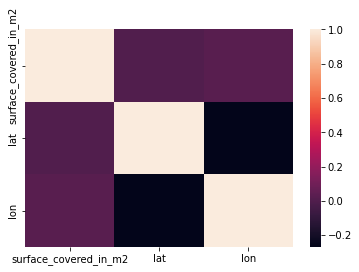

In [13]:
corr = df.select_dtypes('number').drop(columns='price_aprox_usd').corr()
sns.heatmap(corr)

## Split Data

Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [14]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
y_train = df[target]
X_train = df[features]

# Build Model

In [15]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 135527.84
Baseline MAE: 45199.45795261716


## Iterate

In [16]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [17]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24418.69178577092


In [18]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    232482.769827
1    162159.302822
2     65501.422044
3     59756.334717
4    107434.190433
dtype: float64

# Communicate Results

In [19]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        'surface_covered_in_m2': area,
        'lat': lat,
        'lon': lon,
        'neighborhood': neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [20]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $249959.51'

In [21]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=55, description='area', min=31), FloatSlider(value=-34.598543360627154, …

# save the model to disk

In [22]:
import joblib 


joblib.dump(model, 'rf_model.sav')

['rf_model.sav']